<a href="https://colab.research.google.com/github/SantiagoGomezfpv/hyperparameter/blob/main/CNN_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optuna CNN

Este notebook de Colab está diseñado para entrenar y optimizar un modelo de red neuronal convolucional (CNN) utilizando el conjunto de datos MNIST, que contiene imágenes de dígitos escritos a mano. Usaremos la biblioteca Optuna para encontrar la mejor configuración de hiperparámetros para nuestro modelo. A continuación se explica cada parte del código.



## Instalación de Optuna
Primero, instalamos la biblioteca Optuna:

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00


## Importación de Bibliotecas
Luego, importamos las bibliotecas necesarias:

* `optuna` se utiliza para la optimización de hiperparámetros.
* `torch` y `torchvision` son bibliotecas de PyTorch para construir y entrenar modelos de aprendizaje profundo.
* `nn` y `nn.functional` contienen herramientas para crear redes neuronales.
* `optim` se utiliza para los optimizadores.
* `transforms` y `datasets` se utilizan para manejar los datos del conjunto de datos MNIST.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import optuna

## Configuración del Dispositivo
Definimos el dispositivo como CUDA si está disponible, de lo contrario usamos CPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Cargar el Conjunto de Datos MNIST
El conjunto de datos MNIST se compone de imágenes de dígitos escritos a mano. Convertimos las imágenes a tensores y normalizamos los valores de píxeles.

* `transforms.Compose` crea una lista de transformaciones a aplicar a las imágenes.
* `transforms.ToTensor` convierte las imágenes en tensores.
* `transforms.Normalize` normaliza los píxeles de las imágenes.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),                # Convertir las imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizar los valores de píxeles
])

## División del Conjunto de Datos
Descargamos el conjunto de datos MNIST y lo dividimos en conjuntos de entrenamiento y validación. También cargamos el conjunto de prueba.

* `datasets.MNIST` descarga el conjunto de datos MNIST.
* `random_split` divide el conjunto de datos de entrenamiento en dos subconjuntos.
* `DataLoader` carga los datos en mini-lotes para entrenamiento y validación.

In [5]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [54000, 6000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:01<00:00, 5107944.56it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 136215.27it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1282482.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 5283008.53it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Definición de la CNN
Definimos la arquitectura de nuestra red neuronal convolucional (CNN) basada en los hiperparámetros sugeridos por Optuna.

* `nn.Module` es la clase base para todas las redes neuronales en PyTorch.
* `nn.Conv2d` crea una capa convolucional.
* `nn.ReLU` aplica la función de activación ReLU.
* `nn.MaxPool2d` aplica la operación de pooling para reducir la dimensión de las características.
* `nn.Linear` crea una capa completamente conectada.
* `nn.Dropout` aplica la técnica de dropout para evitar el sobreajuste.
* `ModuleList` agrupa las capas en una lista que puede ser iterada.

Optuna está optimizando los siguientes hiperparámetros de la red neuronal:

* `num_conv_layers` Este parámetro define cuántas capas convolucionales tendrá la red. El número de capas puede variar entre 2 y 3.
* `num_filters` Este parámetro define el número de filtros (o canales de salida) en cada capa convolucional. Cada capa puede tener entre 16 y 128 filtros, en incrementos de 16. Para su implementacion se utiliza una lista para almacenar el número de filtros para cada capa, que es determinado por el número de capas convolucionales (num_conv_layers).
* `num_neurons` Este parámetro define cuántas neuronas habrá en la capa totalmente conectada (fully connected layer). El número de neuronas puede variar entre 10 y 400, en incrementos de 10.
* `drop_conv2` Este parámetro controla la probabilidad de dropout en la segunda capa convolucional. La probabilidad de dropout puede variar entre 0.2 y 0.5.
Dropout es una técnica de regularización que ayuda a prevenir el sobreajuste al apagar aleatoriamente algunas neuronas durante el entrenamiento.
* `drop_fc1` Este parámetro controla la probabilidad de dropout en la capa totalmente conectada. La probabilidad de dropout puede variar entre 0.2 y 0.5.Similar al dropout en la capa convolucional, ayuda a prevenir el sobreajuste en la capa totalmente conectada.


In [9]:
class Net(nn.Module):
    def __init__(self, trial):
        tamano = 28
        super(Net, self).__init__()
        # Definir la arquitectura de la red basada en los hiperparámetros sugeridos
        num_conv_layers = trial.suggest_int("num_conv_layers", 2, 3)
        num_filters = [int(trial.suggest_float("num_filter_" + str(i), 16, 128, step=16)) for i in range(num_conv_layers)]
        num_neurons = trial.suggest_int("num_neurons", 10, 400, step=10)
        drop_conv2 = trial.suggest_float("drop_conv2", 0.2, 0.5)
        drop_fc1 = trial.suggest_float("drop_fc1", 0.2, 0.5)

        # Capas convolucionales
        self.convs = nn.ModuleList()
        in_channels = 1  # MNIST tiene imágenes en escala de grises, por lo tanto, 1 canal de entrada
        for out_channels in num_filters:
            tamano = tamano-3+2+1  # 3 es el tamaño del Kernel; 2 es dos veces padding
            tamano = int(tamano/2)
            self.convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            self.convs.append(nn.ReLU())
            self.convs.append(nn.MaxPool2d(2))
            in_channels = out_channels
            if len(self.convs) == 4:  # Aplicar dropout después de la segunda capa convolucional
                self.convs.append(nn.Dropout(drop_conv2))

        # Capa completamente conectada
        self.fc1 = nn.Linear(num_filters[-1] * tamano * tamano, num_neurons)
        self.drop_fc1 = nn.Dropout(drop_fc1)
        self.fc2 = nn.Linear(num_neurons, 10)  # 10 clases en MNIST

    def forward(self, x):
        for layer in self.convs:
            x = layer(x)
        x = x.view(x.size(0), -1)  # Aplanar las características para la capa completamente conectada
        x = F.relu(self.fc1(x))
        x = self.drop_fc1(x)
        x = self.fc2(x)
        return x

## Función Objetivo para Optuna
Definimos una función objetivo para Optuna que optimizará los hiperparámetros del modelo.

* `suggest_int, suggest_discrete_uniform, suggest_float, suggest_categorical, suggest_loguniform`: Optuna prueba diferentes valores de hiperparámetros.
* `CrossEntropyLoss` se utiliza para calcular la pérdida del modelo.
* `optimizer`: Selecciona el optimizador basado en el valor sugerido.
* `model.train()` y `model.eval()` cambian el modo del modelo entre entrenamiento y evaluación.
* `torch.no_grad()` desactiva el cálculo de gradientes para ahorrar memoria durante la evaluación.


In [10]:
def objective(trial):
    # Cargar datos de MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

    # Construir la red neuronal
    model = Net(trial).to(device)

    # Optimizar el tipo de optimizador y la tasa de aprendizaje
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Entrenamiento de la red
    model.train()
    for epoch in range(2):  # limitamos a 2 épocas para el ejemplo
        for data, target in trainloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

    # Validación de la red
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in valloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = correct / total
    return accuracy

## Ejecución de la Optimización
Finalmente, ejecutamos la optimización de hiperparámetros con Optuna.

* `optuna.create_study` crea un estudio de optimización.
* `study.optimize` ejecuta la optimización de la función objetivo durante un número definido de pruebas.
* Se imprimen los mejores hiperparámetros encontrados.

In [11]:
# Crear un estudio de Optuna y encontrar los mejores hiperparámetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)

[I 2024-10-22 01:26:13,023] A new study created in memory with name: no-name-02d0292d-0a25-4efe-92a7-3b9b049f88d5
[I 2024-10-22 01:26:45,786] Trial 0 finished with value: 0.7986666666666666 and parameters: {'num_conv_layers': 3, 'num_filter_0': 112.0, 'num_filter_1': 80.0, 'num_filter_2': 48.0, 'num_neurons': 280, 'drop_conv2': 0.20892402301875385, 'drop_fc1': 0.30623326975368703, 'optimizer': 'SGD', 'lr': 0.00176154177718366}. Best is trial 0 with value: 0.7986666666666666.
[I 2024-10-22 01:27:16,512] Trial 1 finished with value: 0.9385 and parameters: {'num_conv_layers': 2, 'num_filter_0': 48.0, 'num_filter_1': 80.0, 'num_neurons': 60, 'drop_conv2': 0.4410624381667386, 'drop_fc1': 0.4349166401578486, 'optimizer': 'Adam', 'lr': 0.0011471791709627918}. Best is trial 1 with value: 0.9385.
[I 2024-10-22 01:27:46,997] Trial 2 finished with value: 0.9663333333333334 and parameters: {'num_conv_layers': 2, 'num_filter_0': 112.0, 'num_filter_1': 16.0, 'num_neurons': 140, 'drop_conv2': 0.41752

Mejores hiperparámetros: {'num_conv_layers': 3, 'num_filter_0': 16.0, 'num_filter_1': 16.0, 'num_filter_2': 112.0, 'num_neurons': 290, 'drop_conv2': 0.49677209399839994, 'drop_fc1': 0.3507245142408521, 'optimizer': 'SGD', 'lr': 0.07740347263261836}


## Visualización de los Resultados
Optuna proporciona herramientas de visualización para entender mejor los resultados de la optimización. Agregamos visualizaciones para ver la historia de la optimización, las coordenadas paralelas, la importancia de los parámetros, y una vista en corte.

* `plot_optimization_history:` Muestra cómo ha cambiado el valor objetivo a lo largo de los ensayos.
* `plot_parallel_coordinate:` Muestra las relaciones entre los parámetros y el valor objetivo.
* `plot_slice:` Muestra vistas en corte de las relaciones entre los parámetros y el valor objetivo.
* `plot_param_importances:` Muestra la importancia relativa de cada parámetro.

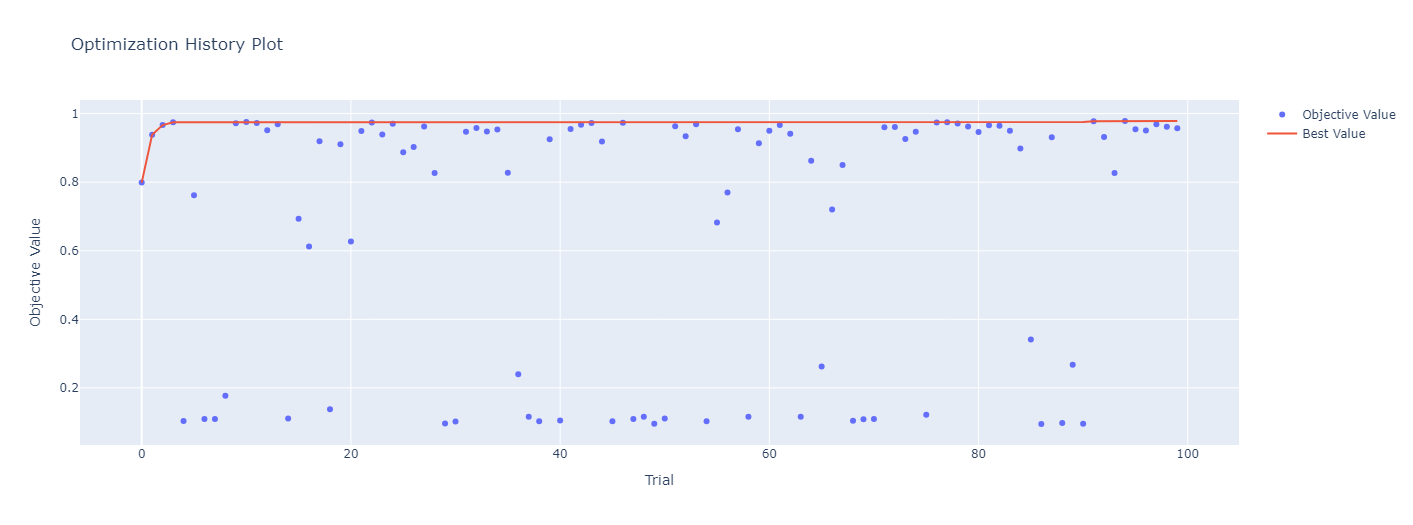

In [14]:
import matplotlib.pyplot as plt
best_params = study.best_params
print(best_params)

optuna.visualization.plot_optimization_history(study)

{'num_conv_layers': 3, 'num_filter_0': 16.0, 'num_filter_1': 16.0, 'num_filter_2': 112.0, 'num_neurons': 290, 'drop_conv2': 0.49677209399839994, 'drop_fc1': 0.3507245142408521, 'optimizer': 'SGD', 'lr': 0.07740347263261836}


In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study, params=['num_conv_layers', 'num_filter_0', 'num_filter_1', 'num_neurons', 'drop_conv2', 'drop_fc1', 'optimizer', 'lr'])

In [ ]:
optuna.visualization.plot_param_importances(study)